### Здравствуйте, меня зовут *Николай Королев*, вот моё Задание №3!

---
# Сравнение моделей регрессии

In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

np.random.seed(228)

In [2]:
rmodels = pd.read_table("rmodels.txt")
rmodels.sample(5)

,err1,err2
567,-1.079576,-1.064624
165,0.515506,0.505304
610,0.437605,0.461757
476,-0.868936,-0.867319
582,-0.172864,-0.158862


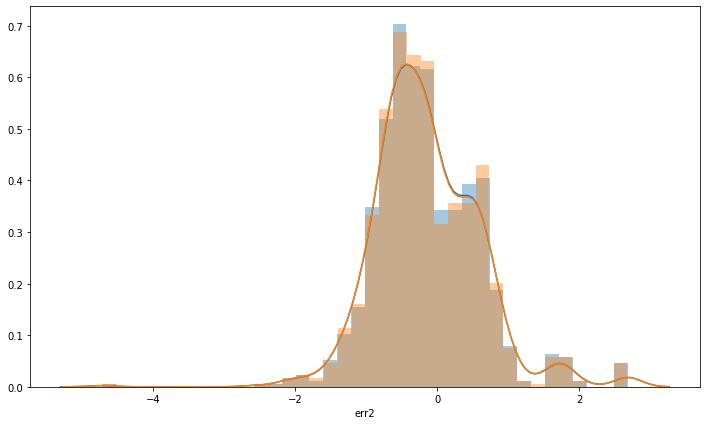

In [3]:
plt.figure(figsize=(12, 7))
sns.distplot(rmodels["err1"])
sns.distplot(rmodels["err2"])
plt.show()

Проверьте данные на нормальность с помощью тестов Колмогорова-Смирнова `kstest(x, 'norm')` и Шапиро-Уилка `shapiro(x)` библиотеки `scipy`. Можно ли использовать qq-график для обоснования использования методов, подразумевающих нормальность? То есть, можем ли мы на основе qq-графика удостовериться в том, что, например, двухвыборочный t-критерий Стьюдента использовать правомернo?

In [4]:
print(scipy.stats.kstest(rmodels["err1"], 'norm'))
print(scipy.stats.kstest(rmodels["err2"], 'norm'))

KstestResult(statistic=0.14963996161911286, pvalue=5.106513019549098e-18)
KstestResult(statistic=0.1508576745490468, pvalue=2.6272748192454066e-18)


In [5]:
print(scipy.stats.shapiro(rmodels["err1"]))
print(scipy.stats.shapiro(rmodels["err2"]))

(0.955877959728241, 8.689481777590516e-16)
(0.956586480140686, 1.198743473327388e-15)


Попробуем воспользоваться методом из `scipy.stats` и из `statsmodels` для построения QQ-графика:

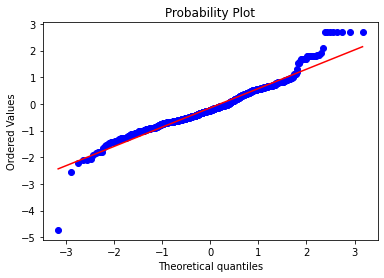

In [6]:
scipy.stats.probplot(rmodels["err1"], plot=plt)
plt.show()

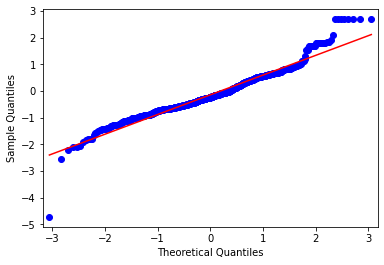

In [7]:
qqplot(rmodels["err1"], line='s')
plt.show()

Видим, что результат один и тот же. Теперь будет пользоваться только методом из `scipy.stats`.

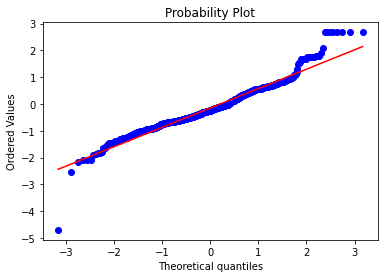

In [8]:
scipy.stats.probplot(rmodels["err2"], plot=plt)
plt.show()

Судя по QQ-графику распределение практически нормальное в наиболее вероятной части распределения (то есть посередине). На краях распределение не повторяет нормального распределения. Критерии Колмогорова-Смирнова и Шапиро-Уилка говорят о том, что мы должны отвергнуть гипотезу о нормальности распределения, тем не менее, эти критерии имеют маленькую мощность, то есть мы можем получить достаточно большую ошибку 2 рода, то есть отвергнем нулевую гипотезу, когда она на самом деле верна.

# Критерий Уилкоксона-Манна-Уитни для независимых выборок.

Первая идея, когда мы слышим слова “гипотеза о равенстве средних”, это конечно t-критерий Стьюдента. Это и понятно – действительно, если данные приходят из нормального распределения, то этот критериий достаточно мощный и использовать следует именно его. Кроме того, этот критерий достаточно устойчив к незначительным отклонениям от нормальности.

При этом на практике и в индустрии подавляющее большинство реальных данных никогда не распределено по нормальному закону. Есть ли хорошие альтернативы этому критерию?

Такой альтернативой, которую часто исопльзуют на практике, является критерий ранговых сумм Уилкоксона-Манна-Уитни. Рассмотрим модель смеси двух нормальных распределений

$$F(x) = (1-\varepsilon)\Phi(x) +\Phi(x/3) $$ 

Интересно, что уже при $\varepsilon \ge 0.01$ критерий ранговых сумм становится более точным критерием (имеет меньшую асимптотическую дисперсию), чем t-критерий. Кроме того есть теорема, что этот критерий не может потерять в асимптотической точности больше, чем $14$% и может быть сколь угодно более точным, чем $t$-критерий. Именно поэтому критерий ранговых сумм так важен для практического применения.

Проверьте гипотезу об однородности двух распределений, из которых получены выборки с помощью критерия Уилкоксона-Манна-Уитни.

# Двухвыборочный перестановочный критерий для независимых выборок.

Другим мощным классом статистических критериев является класс перестановочных критериев.

Чтобы лучше понять сферу применений перестановочного критерия, дадим некоторое его сравнение с $t$-критерием:

- $t$-критерий формирует нулевую гипотезу относительно равенства средних, перестановочные критерии, как правило, задают нулевую гипотезу более широко – в терминах равенства распределений

Двухвыборочный $t$-критерий подразумевает, что нормальным должно быть распределение разностей $\bar{X}_1−\bar{X}_2$, и основывается на том, что правильным образом отнормированная эта разность распределена по закону Стьюдента. Перестановочные критерии считают статистику по данным, не прибегая к гипотезам о конкретном виде распределения, и оценивают распределение с помощью повторных выборок из данных.

- $t$-критерий дает точные значения достигаемого уровня значимости только если разность между средними в двух группах имеет распределение не сильно отклоняющееся от нормального. Перестановочный тест дает точное значение $p_{value}$ даже если распределение очень сильно отклоняется от нормального.

Перестановочный тест часто используется, когда нужна большая точность и предположение о нормальности данных нереалистично, а также для того, чтобы проверить эти предположения.

В частности, для проверки этого предположения часто прибегают к следующей процедуре. Из объединенной выборки выбирают случайно по схеме без возвращения столько объектов, сколько было изначально в одной из них (скажем, в первой). Остальные объекты полагают попавшими во вторую группу. Дальше считают некоторую статистику (в данном случае разницу средних значениях в этих двух группах) и ее запоминают.

Повторяя такую процедуру много раз, достигаемый уровень значимости получают как долю значений статистики (разности средних в нашем примере) таких же или более экстремальных, чем значение статистики, которое получилось по исходным выборкам (из которых мы делаем псевдовыборки). Если это значение находится далеко от $p_{value}$ $t$-критерия, то считается, что $t$-критерий для этих данных ненадежен.

Тонкий вопрос о том, сколько нужно сделать таких псевдовыборок, решают следующим образом. Если истинное значение достигаемого уровня значимости равно $p$, то стандартное отклонение оценки $p_{value}$ равно $\sqrt{p(1−p)/B}$, где $B$ - это количество сделанных псевдовыборок. Часто также переходят к верхней оценке этого значения $(\sqrt{1/(4B)})$.

- Реализуйте подобную процедуру самостоятельно для точности порядка $10^{-4}$.
- Cравните получившееся p-value с таковым для $t$-критерия.
- Cравните получившееся p-value с таковым для критерия Манна-Уитни `mannwhitneyu`.

# Двухвыборочный перестановочный критерий для зависимых выборок.

В случае, если выборки связаны, то предыдущая схема неприменима: нет смысла переставлять значения между разными объектам. В таком случае прибегают к тому, что переставляют значения внутри каждого объекта, получая таким образом новые псевдовыборки, по которым также считают статистику и запоминают ее. Повторяя такую процедуру много раз, $p_{value}$ находят также, как и в предыдущем случае – считая долю таких же или еще более экстремальных значений статистики по псевдовыборкам в сравнении со статистикой, посчитанной по исходной выборке.

- Реализуйте описанную процедуру самостоятельно для точности порядка $10^{-4}$.
- Cравните получившееся $p_{value}$ с таковым для t-критерия.
- Cравните получившееся $p_{value}$ с таковым для критерия Уилкоксона `wilcoxon`.

Не забудьте, что вам в данном случае каждый из критериев нужно вызвать с параметрами, соответствующими связанным выборкам.

# Выводы